In [22]:
%run Function_Master.ipynb 
%run Parameterization.ipynb

## Defining Parameterization and Initial Conditions

In [23]:
print_paramterization(param)

╒════════════════════════════════════════╤═══════════════╤═════════════════╤═══════════════╤══════════════════════╕
│ V_max = 1.4                            │ λ_P = 0.05    │ μ_V = 1.0       │ μ_P = 0.4     │ K_I = 1.0            │
├────────────────────────────────────────┼───────────────┼─────────────────┼───────────────┼──────────────────────┤
│ γ_Z = 0.4                              │ λ_Z = 0.05    │ μ_V_prime = 1.6 │ μ_delta = 0.4 │ K_h = 1.0            │
├────────────────────────────────────────┼───────────────┼─────────────────┼───────────────┼──────────────────────┤
│ φ = 110236.2205                        │ λ_Z_hat = 0.1 │ μ_u = 0.0       │ μ_g = 0.4     │ K_P = 2.8            │
├────────────────────────────────────────┼───────────────┼─────────────────┼───────────────┼──────────────────────┤
│ g = 1.4                                │ λ_E = 0.3     │ μ_r = 0.5       │ μ_Z = 0.4     │ I_0 = e - 1 = 1.7183 │
├────────────────────────────────────────┼───────────────┼──────────────

## Running and Sorting Simulations

In [24]:
"""
Defines certain criteria for the numerical integration scheme.

Individual tolerances are perscribed to each state based on knowledge of
their probable values.
"""
t_span = 1000

# Total N span
points = 200
N_t = np.logspace(-4, 1, points) * 2

max_step   = .1
method     = 'LSODA'
tolerances = [1e-8, 1e-8, 1e-12, 1e-8, 1e-8, 1e-10, 1e-10]

In [25]:
%%time

"""
This cell defines the level for which each state shall be initialized based
on a reasonable ratio of total nutrients as nutrients increase in the system.

Numerically integrating equations for each initial condition configuration. 
"""
sols = []

Nn_0 = 0.
Pi_0 = 0.
Vi_0 = 0.

for Nt in N_t:
    
    # Define Phytoplankton and Zooplankton as certain percentages
    Pu_0 = .1 * Nt  
    Z_0  = .2 * Nt 
    
    #Initial level of Ve is computed based on the ratio of hosts to viruses
    r = 1/10
    Ve_0 = est_viral_abund(r, Pu_0, alpha, beta, S_ind, V_ind)
    
    # Define nutrient level as the remainder
    Nr_0 = Nt - (Pu_0 + Z_0 + Ve_0)
    
    # Define initial condition array
    z0 = [Nn_0, Nr_0, Pu_0, Pi_0, Z_0, Vi_0, Ve_0]
    
    solution = solve_ivp(model, [0, t_span], z0, args=param,
                         max_step=max_step, method=method, atol=tolerances)     
    
    #returns list of initial conditions + solution object
    sols.append((z0, solution))

len(sols)

CPU times: user 13 s, sys: 289 ms, total: 13.3 s
Wall time: 13.3 s


200

In [26]:
%store sols 

Stored 'sols' (list)


## Visualization of Results

In [133]:
%store -r sols

In [8]:
#Parameters for printing in plot

param_labels_fp = ['V_max', 'γ_Z', 'φ', 'g', 'ν_x', 
               'λ_P', 'λ_Z', 'λ_Z_hat', 'λ_E', 'δ', 'μ_V', 'μ_V_prime', 'μ_u', 'μ_r', 'μ_s', 
               'μ_P', 'μ_delta', 'μ_g', 'μ_Z', 'K_N', 'K_I', 'K_h', 'K_P', 'I_0 = e - 1', 'ω']

param_fp = [f'{param_labels_fp[i]} = {param[i]:.4}' for i in range(len(param))]
param_fp = np.reshape(param_fp, (5,5)).transpose()

#### Annimation Block

In [10]:
%matplotlib tk

"""
Animation of sorted solutions.
"""

time = [(z0, solution.t) for z0, solution in sols]

Nn = [solution.y[0] for z0, solution in sols]
Nr = [solution.y[1] for z0, solution in sols]
PU = [solution.y[2] for z0, solution in sols]
PI = [solution.y[3] for z0, solution in sols]
Z  = [solution.y[4] for z0, solution in sols]        
VI = [solution.y[5] for z0, solution in sols]
VE = [solution.y[6] for z0, solution in sols]

states = [Nn, Nr, PU, PI, Z, VI, VE]

fig = plt.figure(1, figsize=(12, 15))
ax = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

def animate(i):
    ax.clear()
    ax2.clear()
    ax3.clear()
    
    for a in [ax, ax2]:
        a.plot(time[i][1], Nn[i], color="darkviolet", label = "N_n")
        a.plot(time[i][1], Nr[i], color="blue"      , label = "N_r")
        a.plot(time[i][1], PU[i], color="aquamarine", label = "P_U")
        a.plot(time[i][1], PI[i], color="limegreen" , label = "P_I")
        a.plot(time[i][1], Z[i], color="darkgreen" , label = "Z ")
        a.plot(time[i][1], VI[i], color="red"       , label = "V_I")
        a.plot(time[i][1], VE[i], color="darkred"   , label = "V_E")
    
        a.set(ylabel = r'Nutrients ($mmol/m^3$)')
        a.grid(which='both', alpha=.3)
        a.minorticks_on()
        a.legend(loc=(.98, 0.05), framealpha=1)
        
    title = (f'Total N: {sum(time[i][0]):.8}, '
             f'for Nr_0 = {time[i][0][1]:.4}, '
             f'Pu_0 = {time[i][0][2]:.4}, '
             f'Pi_0 = {time[i][0][3]:.4}, '
             f'Z_0 = {time[i][0][4]:.4}, '
             f'Vi_0 = {time[i][0][5]:.4}, '
             f'Ve_0 = {time[i][0][6]:.4}')

    ax.set_title(title, pad=15)

    ax2.set_xlabel('Time (Day)')
    ax2.set_yscale('log')
    ax2.set_ylim(1e-12, 3e1)
    
    ax3.text(0, -1.49, f"Number of simulations: {len(sols)}", weight='bold', transform=ax.transAxes)
    
    ax3.text(0,-1.58, 'Functional Calls:', weight='bold', transform=ax.transAxes)   
    ax3.text(0,-1.65, f"Integration Method: {method},", transform=ax.transAxes)
    ax3.text(.2, -1.65, f"Max time step: {max_step},", transform=ax.transAxes)
    ax3.text(.34, -1.65, f"Absolute state tolerances: {tolerances}", transform=ax.transAxes)

    ax3.text(0, -1.75, f"Final state values:", weight='bold', transform=ax.transAxes)
    
    ax3.text(0, -1.82, f"N_n:  {Nn[i][-1]},", transform=ax.transAxes)
    ax3.text(.25, -1.82, f"N_r:   {Nr[i][-1]},", transform=ax.transAxes)
    ax3.text(0, -1.9, f"P_U:  {PU[i][-1]},", transform=ax.transAxes)
    ax3.text(.25, -1.9, f"P_I:   {PI[i][-1]},", transform=ax.transAxes)
    ax3.text(0, -1.98, f"Z:     {Z[i][-1]},", transform=ax.transAxes)
    ax3.text(0, -2.06, f"V_I:   {VI[i][-1]},", transform=ax.transAxes)
    ax3.text(.25, -2.06, f"V_E:  {VE[i][-1]}", transform=ax.transAxes)
    
    ax3.text(0, -2.16, "Parameterization: ", weight='bold', transform=ax.transAxes)

    table = ax3.table(cellText=param_fp, bbox=[0, -.2, 1, .5], cellLoc='left')
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(.7, 2)
    
    ax3.get_xaxis().set_visible(False)
    ax3.get_yaxis().set_visible(False)
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    ax3.spines['bottom'].set_visible(False)
    ax3.spines['left'].set_visible(False)

fig.tight_layout(pad=5)
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(sols))
plt.show()

#### File storage

In [9]:
%%time

"""
File storage directly to specified directory; exporting as mp4.
"""
# SET FILE NAME
# f = "/Users/jholmes/Desktop/NCAR/Simulation Annimations/Fixed Initial Condition Ratio/Base_Parameterization_variying_Nt.mp4"
writermp4 = matplotlib.animation.FFMpegWriter(fps=60)
ani.save(f, writer=writermp4)

NameError: name 'f' is not defined

### Bifurcation Diagram

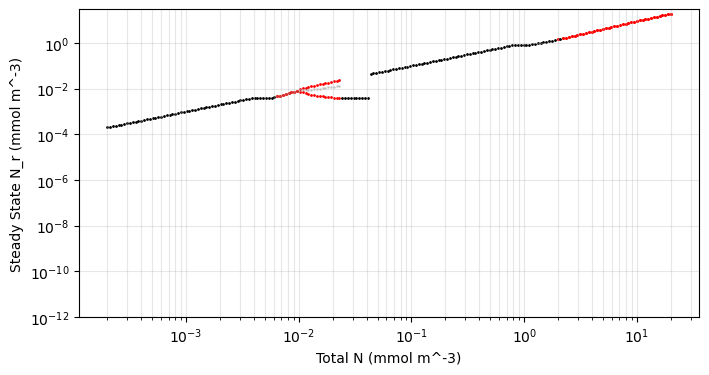

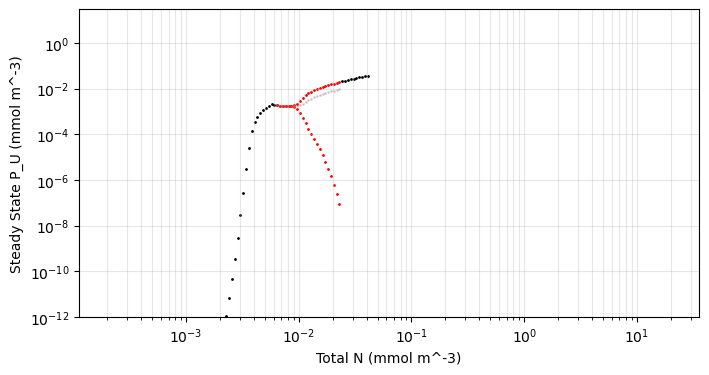

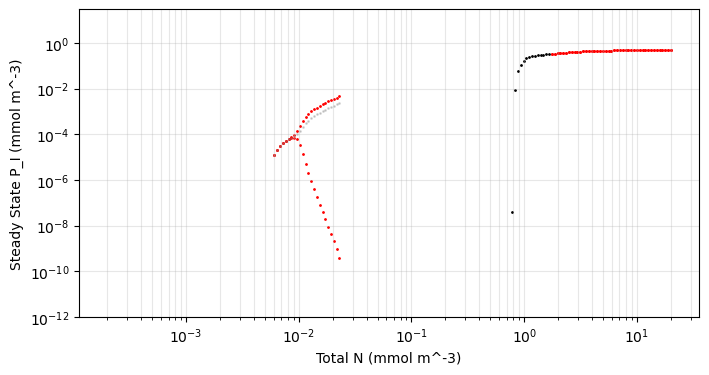

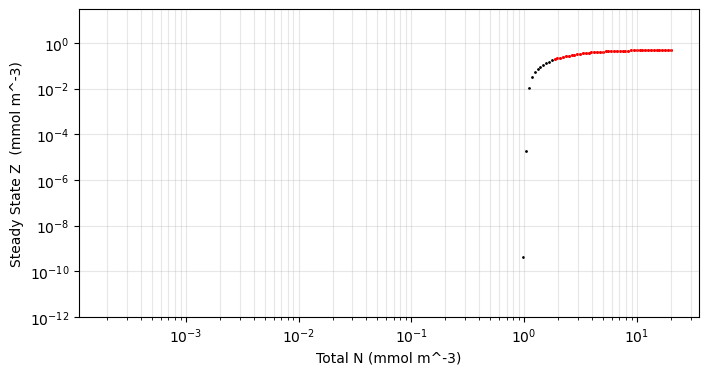

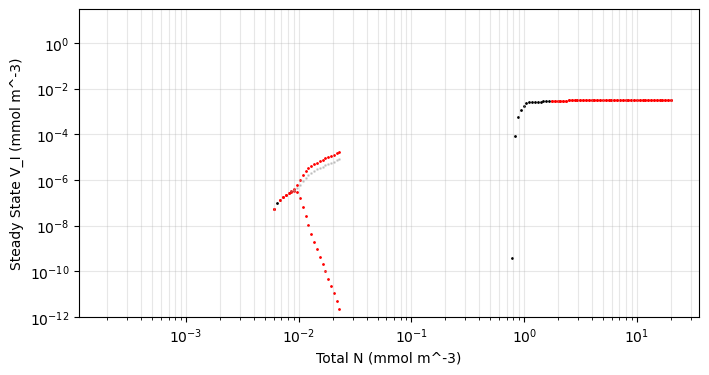

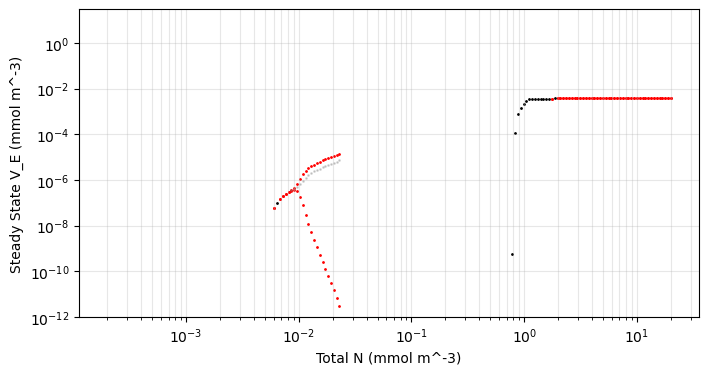

In [30]:
%matplotlib inline 

state_labels = ["N_n", "N_r", "P_U", "P_I", "Z ", "V_I", "V_E"]


for i in range(1, 7):
    
    plt.figure(figsize=(8, 4))
    for sol in sols:

        z0, state_sol = sol[0], sol[1].y[i]
        
        chunk = int(len(sol[1].t) * .85) #Last 15% of time span
        y_end = state_sol[chunk: ]    #look at tail end of specific state
        
        l_min = argrelmin(y_end)[-1]  #Extracting local minimum 
        l_max = argrelmax(y_end)[-1]  #and maximum

        if len(l_min == 0) and len(l_max == 0):
            
            plt.scatter(sum(z0), state_sol[chunk + l_min[-1]], color='red', s=1)
            plt.scatter(sum(z0), state_sol[chunk + l_max[-1]], color='red', s=1)

            if y_end[l_max[-1]] - y_end[l_min[-1]] > 1e-8:
                mean = (state_sol[chunk + l_min[-1]] + state_sol[chunk + l_max[-1]]) / 2
                plt.scatter(sum(z0), mean, color='grey', s=1, alpha=.3)

        else: plt.scatter(sum(z0), state_sol[-1], color='black', s=1)

    plt.xscale('log')
    plt.yscale('log')
    plt.ylim(1e-12, 30)
    plt.grid(which='both', alpha=.3)
    
    plt.ylabel(f"Steady State {state_labels[i]} (mmol m^-3)")
    plt.xlabel(f"Total N (mmol m^-3)")
    plt.show()

In [88]:
ss_sols = []
osc_sols = []

for z0, sol in sols: 
    
    info = ss_or_osc(sol)
    
    if len(info) > 1 :
        osc_sols.append([z0, sol] + list(info[1]))
        
    else:
        ss_sols.append([z0, sol] + list(info))
        

ValueError: x and y must be the same size

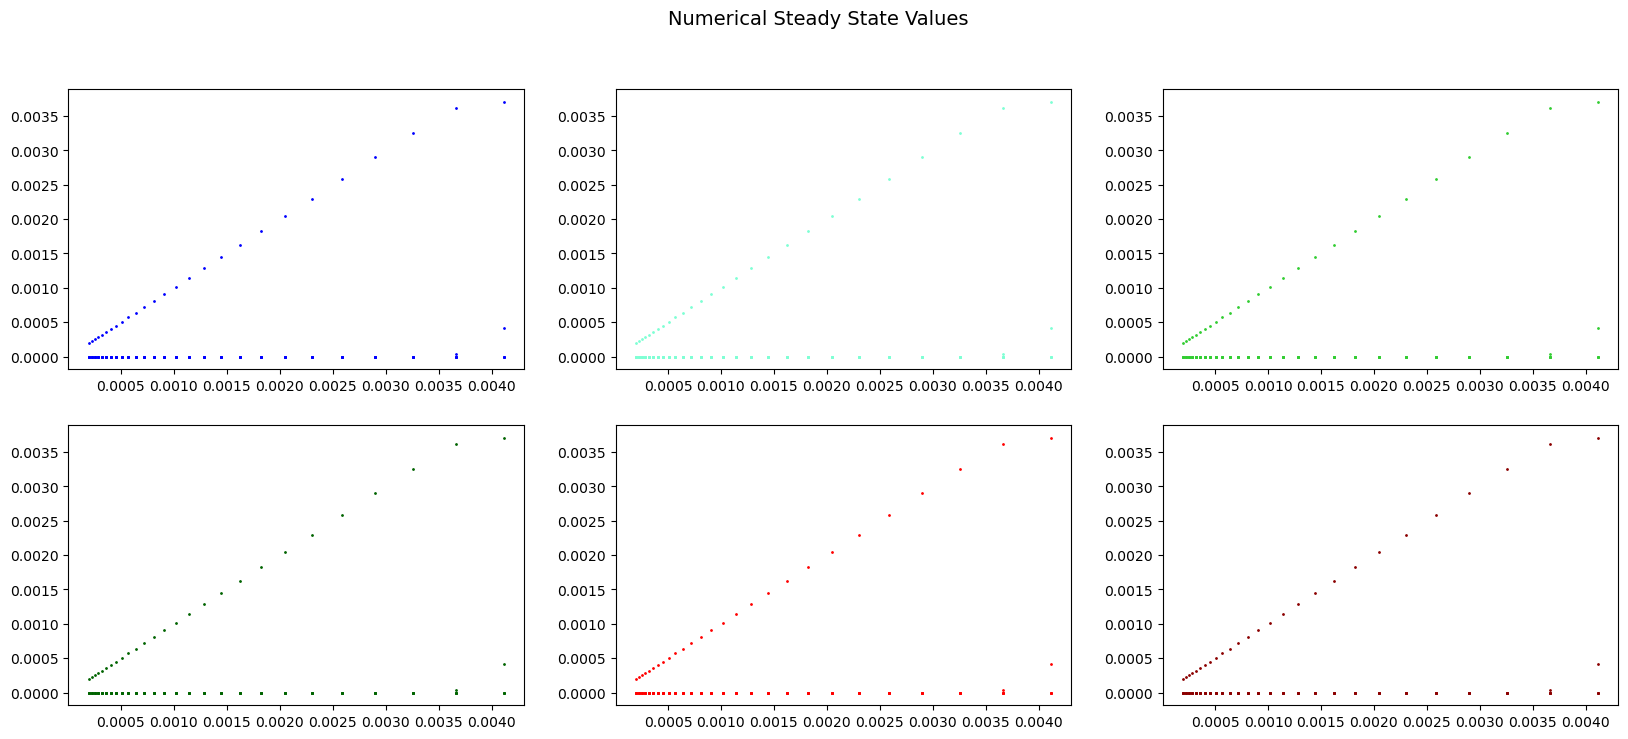

In [86]:
%matplotlib inline 

fifig, axs = plt.subplots(2, 3, figsize=(20, 8))

fig.suptitle("Numerical Steady State Values", fontsize=14)

state_labels = [["N_r", "P_U", "P_I"], ["Z ", "V_I", "V_E"]]

N_T   = [sum(z0) for z0, sol, ss, con_ind in ss_sols]
ss_Nn = [ss[0] for z0, sol, ss, con_ind in ss_sols]
ss_Nr = [ss[1] for z0, sol, ss, con_ind in ss_sols]
ss_Pu = [ss[2] for z0, sol, ss, con_ind in ss_sols]
ss_Pi = [ss[3] for z0, sol, ss, con_ind in ss_sols]
ss_Z  = [ss[4] for z0, sol, ss, con_ind in ss_sols]
ss_Vi = [ss[5] for z0, sol, ss, con_ind in ss_sols]
ss_Ve = [ss[6] for z0, sol, ss, con_ind in ss_sols]

axs[0][0].scatter(N_T, ss_Nr, color="blue"      , label = "N_r", s=1)
axs[0][1].scatter(N_T, ss_Pu, color="aquamarine", label = "P_U", s=1)
axs[0][2].scatter(N_T, ss_Pi, color="limegreen" , label = "P_I", s=1)
axs[1][0].scatter(N_T, ss_Z,  color="darkgreen" , label = "Z " , s=1)
axs[1][1].scatter(N_T, ss_Vi, color="red"       , label = "V_I", s=1)
axs[1][2].scatter(N_T, ss_Ve, color="darkred"   , label = "V_E", s=1)

for i, ax in enumerate(axs):
    for j, subax in enumerate(ax):
        subax.grid(which='both', alpha=.3)
        subax.set_xscale('log')
        # subax.set_yscale('log')
        # subax.set_ylim(1e-15, 30)
        subax.set_xlabel('Total N (mmol m^-3)', fontsize=12)
        subax.set_ylabel(f'{state_labels[i][j]} (mmol m^-3)', fontsize=12)
        
plt.tight_layout()


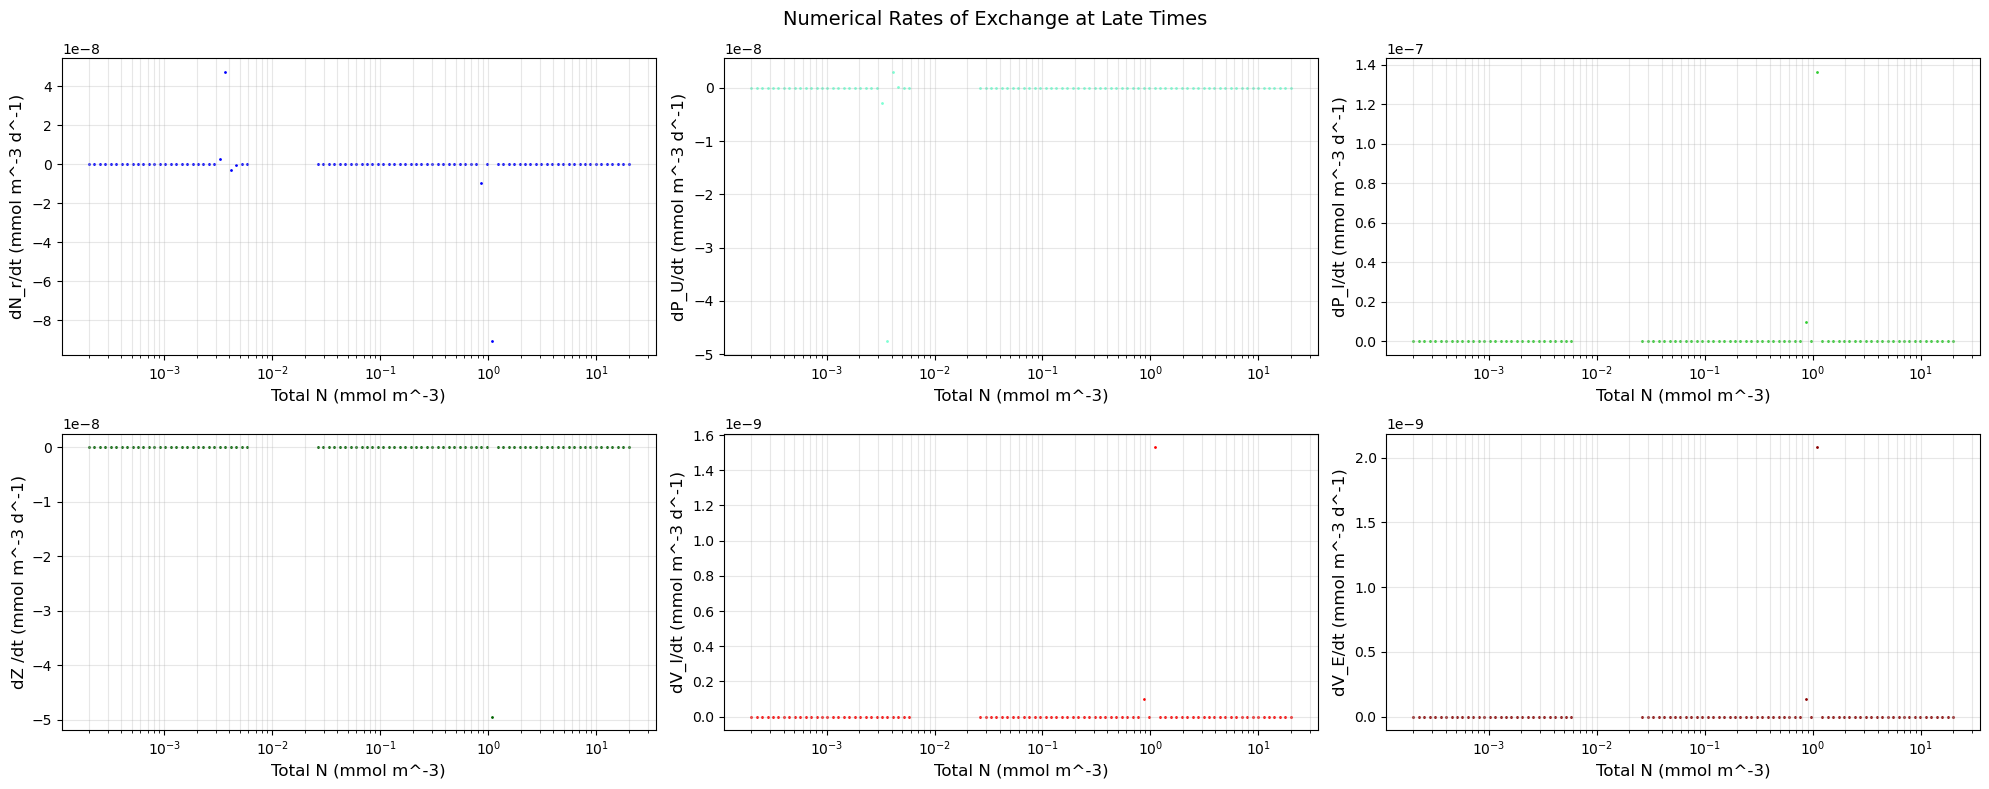

In [62]:
%matplotlib inline 

fig, axs = plt.subplots(2, 3, figsize=(20, 8))

fig.suptitle("Numerical Rates of Exchange at Late Times", fontsize=14)

state_labels = [["N_r", "P_U", "P_I"], ["Z ", "V_I", "V_E"]]

N_T   = [sum(z0) for z0, sol, ss, con_ind in ss_sols]
rate_Nn = [rates_of_change(ss, param)[0] for z0, sol, ss, con_ind in ss_sols]
rate_Nr = [rates_of_change(ss, param)[1] for z0, sol, ss, con_ind in ss_sols]
rate_Pu = [rates_of_change(ss, param)[2] for z0, sol, ss, con_ind in ss_sols]
rate_Pi = [rates_of_change(ss, param)[3] for z0, sol, ss, con_ind in ss_sols]
rate_Z  = [rates_of_change(ss, param)[4] for z0, sol, ss, con_ind in ss_sols]
rate_Vi = [rates_of_change(ss, param)[5] for z0, sol, ss, con_ind in ss_sols]
rate_Ve = [rates_of_change(ss, param)[6] for z0, sol, ss, con_ind in ss_sols]

axs[0][0].scatter(N_T, rate_Nr, color="blue"      , label = "N_r", s=1)
axs[0][1].scatter(N_T, rate_Pu, color="aquamarine", label = "P_U", s=1)
axs[0][2].scatter(N_T, rate_Pi, color="limegreen" , label = "P_I", s=1)
axs[1][0].scatter(N_T, rate_Z,  color="darkgreen" , label = "Z " , s=1)
axs[1][1].scatter(N_T, rate_Vi, color="red"       , label = "V_I", s=1)
axs[1][2].scatter(N_T, rate_Ve, color="darkred"   , label = "V_E", s=1)

for i, ax in enumerate(axs):
    for j, subax in enumerate(ax):
        subax.grid(which='both', alpha=.3)
        subax.set_xscale('log')
        # subax.set_yscale('log')
        # subax.set_ylim(1e-15, 30)
        subax.set_xlabel('Total N (mmol m^-3)', fontsize=12)
        subax.set_ylabel(f'd{state_labels[i][j]}/dt (mmol m^-3 d^-1)', fontsize=12)
        
plt.tight_layout()
plt.show()